In [20]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 446.8/776.4 MB 198.4 MB/s eta 0:00:02

In [21]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import timm

from sklearn.cluster import KMeans

SEED = 6174
np.random.seed(SEED)

# Set the folder path for data
folder_path = "./input"

In [2]:
de_train = pd.read_parquet(f'{folder_path}/de_train.parquet')
genes = de_train.columns[5:]
id_map = pd.read_csv (f'{folder_path}/id_map.csv')
id_map = id_map.reindex(id_map.columns.tolist() + genes.tolist(), axis=1)

sm_lincs_id = de_train.set_index('sm_name')["sm_lincs_id"].to_dict()
sm_name_to_smiles = de_train.set_index('sm_name')['SMILES'].to_dict()

id_map['sm_lincs_id'] = id_map['sm_name'].map(sm_lincs_id)
id_map['SMILES'] = id_map['sm_name'].map(sm_name_to_smiles)

de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [3]:
## Drop cell_type = 'T cells CD4+', 'T cells CD8+'
#de_train.drop(de_train[de_train['cell_type'] == 'T cells CD4+'].index, inplace = True)
#de_train.drop(de_train[de_train['cell_type'] == 'T cells CD8+'].index, inplace = True)

#de_train

In [4]:
all_sm_names = de_train[de_train["cell_type"]=="B cells"]["sm_name"].to_list()
all_de_train = de_train[de_train["sm_name"].isin(all_sm_names)]
#de_train.drop(all_de_train.index, inplace=True)

all_de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
8,B cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.394173,-0.153824,0.178232,0.566241,0.391377,...,-1.052302,-1.176587,-1.220291,-0.278944,-0.095066,1.101790,0.061803,1.406335,-0.264996,-0.119743
9,Myeloid cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.025146,0.316388,1.366885,1.301593,2.317619,...,-0.902546,-1.445523,0.794772,0.428973,0.605834,0.271988,0.492231,0.354721,1.471559,-0.259483
10,NK cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.861487,-0.112313,-0.355217,0.719999,0.655865,...,0.035687,0.138060,-0.776619,-0.109832,-0.189906,0.753086,0.190892,-0.141699,-0.756510,-0.076934
11,T cells CD4+,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.206471,0.014638,-0.247518,0.430198,0.103020,...,-0.018902,-1.013426,-1.196254,-0.983257,1.097309,-0.090271,-1.293485,0.118196,-0.120892,-0.411331
12,T cells CD8+,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.046959,-0.346839,0.023478,0.485611,0.005066,...,0.017437,0.537964,-0.219895,0.376181,0.706930,-0.554368,0.035559,-0.189976,-0.145465,0.109084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,Myeloid cells,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,0.338227,-0.431007,0.066335,-0.907600,0.973881,...,0.187125,0.800574,0.214946,-0.104931,-0.125619,-0.160210,-0.886414,-2.955785,-0.866944,-0.053017
558,NK cells,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,-1.026443,-0.024840,0.204772,-0.861985,-2.972540,...,0.323512,1.131738,-0.064157,0.011429,0.030404,0.015837,-0.055027,-0.329874,0.327199,-0.830306
559,T cells CD4+,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,-0.545092,0.108150,-0.355024,-1.659293,-0.613075,...,2.537207,-0.429731,-0.605248,0.304310,-0.014653,0.000120,-1.117706,-0.130162,0.001642,-0.665771
560,T cells CD8+,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,0.342721,0.921447,-2.992502,-0.842775,-0.408755,...,0.240196,0.302058,-0.555482,-0.009563,0.029517,0.037701,-0.257844,-1.374965,-1.202369,-0.676311


In [5]:
grouped_all_de = all_de_train.groupby('cell_type')[genes].mean().reset_index()
grouped_all_de

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
1,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
2,NK cells,1.726861,1.391056,-0.384683,-0.909542,0.735264,4.687871,0.460742,1.023145,0.046517,...,0.511199,0.462575,0.388045,0.784062,0.945736,1.232050,0.106880,0.600556,-0.585519,-0.156448
3,T cells CD4+,0.160548,0.469133,-0.074140,-1.055539,0.006779,2.138308,-0.247477,0.669044,0.630691,...,1.231267,0.601618,0.150675,0.811554,0.616685,0.330778,0.181473,0.175703,-0.472213,-0.099220
4,T cells CD8+,-0.259045,-0.142500,-0.402029,-0.313932,-0.436765,-0.769503,-0.118564,0.039057,-0.710979,...,0.135679,0.029111,-0.293163,-0.188252,0.014929,-0.223888,0.110891,-0.155235,-0.318527,0.253286
5,T regulatory cells,1.740391,1.263407,2.306707,2.578485,2.978225,2.920715,0.274367,1.225981,0.012020,...,-0.018877,1.311463,0.817281,1.549286,2.184906,2.333129,1.334974,0.791717,-0.092324,-0.028916


In [6]:
diff_all_de = grouped_all_de.copy()
diff_all_de[genes] = grouped_all_de.loc[:, genes] - grouped_all_de.loc[:, genes].mean(axis=0)
diff_all_de.columns = ['cell_type'] + ['cell_diff_' + i for i in genes]
diff_all_de

,cell_type,cell_diff_A1BG,cell_diff_A1BG-AS1,cell_diff_A2M,cell_diff_A2M-AS1,cell_diff_A2MP1,cell_diff_A4GALT,cell_diff_AAAS,cell_diff_AACS,cell_diff_AAGAB,...,cell_diff_ZUP1,cell_diff_ZW10,cell_diff_ZWILCH,cell_diff_ZWINT,cell_diff_ZXDA,cell_diff_ZXDB,cell_diff_ZXDC,cell_diff_ZYG11B,cell_diff_ZYX,cell_diff_ZZEF1
0,B cells,0.327560,-0.180123,1.352505,1.130703,2.449224,0.842276,-0.111469,-0.106265,0.573477,...,-0.049993,0.178906,0.222007,0.734422,-0.146888,-0.229706,0.339398,0.267314,0.120982,0.082503
1,Myeloid cells,0.517006,0.041857,-2.845133,0.424241,4.180583,1.263995,0.302835,-0.247358,0.046682,...,-0.578193,-0.599389,-1.303331,-0.871264,0.783797,-0.198328,-0.881573,-0.678362,0.035306,-0.064420
2,NK cells,0.673531,0.680349,-0.372990,-1.373146,-1.743063,1.916955,0.320633,0.372244,-0.103086,...,0.203429,-0.033497,0.392666,0.079110,-0.154055,0.421041,-0.191131,0.350132,-0.257445,-0.153144
3,T cells CD4+,-0.892782,-0.241575,-0.062447,-1.519142,-2.471549,-0.632608,-0.387585,0.018143,0.481089,...,0.923497,0.105547,0.155296,0.106602,-0.483106,-0.480230,-0.116537,-0.074720,-0.144140,-0.095916
4,T cells CD8+,-1.312375,-0.853207,-0.390336,-0.777536,-2.915092,-3.540418,-0.258673,-0.611844,-0.860581,...,-0.172092,-0.466960,-0.288541,-0.893204,-1.084862,-1.034897,-0.187120,-0.405658,0.009547,0.256590
5,T regulatory cells,0.687061,0.552699,2.318400,2.114881,0.499897,0.149800,0.134258,0.575080,-0.137582,...,-0.326647,0.815392,0.821903,0.844334,1.085114,1.522120,1.036963,0.541294,0.235750,-0.025612


In [7]:
grouped_sm_name = de_train.groupby('sm_name')[genes].mean().reset_index()
grouped_sm_name

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
142,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
143,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
144,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


In [8]:
diff_sm_name = grouped_sm_name.copy()
diff_sm_name[genes] = grouped_sm_name.loc[:, genes] - grouped_sm_name.loc[:, genes].mean(axis=0)
diff_sm_name.columns = ['sm_name'] + ['sm_diff_' + i for i in genes]
diff_sm_name

,sm_name,sm_diff_A1BG,sm_diff_A1BG-AS1,sm_diff_A2M,sm_diff_A2M-AS1,sm_diff_A2MP1,sm_diff_A4GALT,sm_diff_AAAS,sm_diff_AACS,sm_diff_AAGAB,...,sm_diff_ZUP1,sm_diff_ZW10,sm_diff_ZWILCH,sm_diff_ZWINT,sm_diff_ZXDA,sm_diff_ZXDB,sm_diff_ZXDC,sm_diff_ZYG11B,sm_diff_ZYX,sm_diff_ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,-0.039395,-0.345517,0.251106,1.329289,0.129028,-0.169352,0.130167,-0.127192,-0.880915,...,-0.829229,-0.836877,0.276604,0.005846,0.078758,0.469321,0.202776,0.275210,-0.067931,0.628029
1,ABT-199 (GDC-0199),-0.420948,-0.225771,-0.080797,-0.265121,-0.384739,-0.633526,-0.155760,-0.314197,0.313317,...,0.371135,-0.052012,-0.115658,-0.395347,-0.260198,-0.434497,-0.128487,-0.338946,0.220022,-0.017105
2,ABT737,0.068350,0.089489,-0.054590,-0.188518,-0.181925,0.259709,0.756669,-0.148642,-0.125301,...,0.126892,-0.326908,0.001171,0.158677,-0.309542,-0.040966,0.014791,-0.226833,0.015960,-0.651902
3,AMD-070 (hydrochloride),-0.370793,0.300563,-0.037300,0.102140,-0.621964,-0.852167,-0.169157,0.468904,-0.023748,...,-0.160491,-0.081537,0.166001,0.055975,-0.457713,-0.224137,-0.241387,0.047273,0.074107,0.242463
4,AT 7867,-0.096926,-0.508925,-0.003726,0.128022,-0.607554,-0.708261,-0.223482,-0.175800,-0.245014,...,-0.764335,-0.235659,-0.147556,-0.592320,-0.425285,0.098030,-0.398984,0.465425,0.174328,0.155341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Vandetanib,-0.345738,-0.905832,-0.392376,-0.632290,-0.494782,-1.420797,0.035244,-0.183037,-0.134386,...,0.053915,-0.203713,-0.402700,-0.353517,-0.679766,-0.681909,-0.136064,-0.161991,0.287228,0.330168
142,Vanoxerine,-0.151660,-0.692723,-0.054619,0.303286,-0.315552,-0.652188,-0.186360,-0.595754,-0.153215,...,-0.036431,-0.261755,0.121355,-0.088520,-0.256189,-0.464349,-0.433037,0.201257,-0.095044,-0.145256
143,Vardenafil,-0.436981,0.293710,-0.501227,-0.295938,-0.582625,-1.161039,-0.211804,-0.786058,0.043766,...,-0.015604,-0.096371,0.501841,-0.091881,-0.396896,-0.460252,-0.396746,0.034604,0.477230,-0.309196
144,Vorinostat,-0.264454,-0.218510,0.292010,-0.148821,-0.261645,-1.118468,0.521841,0.507720,1.739685,...,0.261168,0.395262,-0.429197,-0.359144,-1.062815,0.013980,-0.348943,0.055201,0.122221,0.346611


In [9]:
def split_sign(text):
    text = text.replace(')(', ' ')
    text = text.replace('(' , ' ')
    text = text.replace(')' , ' ')
    return text.split(" ")

de_train['_SMILES'] = [split_sign(text) for text in de_train['SMILES'].values]

sign = []
for row in de_train['_SMILES'].values:
    for ele in row:
        sign.append(ele)
        
sign_list = list(set(sign))

data = np.zeros((len(de_train), len(sign_list)), dtype=int)
de_features = pd.DataFrame(data=data, columns=sign_list)

for sign in sign_list:
    for i in range(len(de_train)):
        row = de_train['_SMILES'].values[i]

        for ele in row:
            if ele == sign:
                de_features[sign][i] += 1

                
id_map['_SMILES'] = [split_sign(text) for text in id_map['SMILES'].values]

sign = []
for row in id_map['_SMILES'].values:
    for ele in row:
        sign.append(ele)
        
sign_list = list(set(sign))

data = np.zeros((len(id_map), len(sign_list)), dtype=int)
test_features = pd.DataFrame(data=data, columns=sign_list)

for sign in sign_list:
    for i in range(len(id_map)):
        row = id_map['_SMILES'].values[i]

        for ele in row:
            if ele == sign:
                test_features[sign][i] += 1
                
uncommon = [f for f in de_features if f not in test_features]
de_features = de_features.drop(columns=uncommon)

de_features = de_features.sort_index(axis = 1)
test_features = test_features.sort_index(axis = 1)

print("Columns Check", list(de_features.columns) == list(test_features.columns))

Columns Check True


In [10]:
# Connect de_train and diff_all_de by cell_type
features = ["cell_type", "sm_name"]
de_train.reset_index(inplace=True)

X = de_train[features].copy()
X = pd.merge(X, diff_all_de, on='cell_type', how='left')
X = pd.merge(X, diff_sm_name, on='sm_name', how='left')
X = pd.merge(X, de_features, left_index=True, right_index=True, how='left')
X.drop(features, axis=1, inplace=True)
X

,cell_diff_A1BG,cell_diff_A1BG-AS1,cell_diff_A2M,cell_diff_A2M-AS1,cell_diff_A2MP1,cell_diff_A4GALT,cell_diff_AAAS,cell_diff_AACS,cell_diff_AAGAB,cell_diff_AAK1,...,no2,noc1C,noc4C,o1,oc6,on4,s2,s3,sc2cc,sc3cc
0,0.673531,0.680349,-0.372990,-1.373146,-1.743063,1.916955,0.320633,0.372244,-0.103086,0.038950,...,0,0,0,0,0,0,0,0,0,0
1,-0.892782,-0.241575,-0.062447,-1.519142,-2.471549,-0.632608,-0.387585,0.018143,0.481089,-0.513731,...,0,0,0,0,0,0,0,0,0,0
2,-1.312375,-0.853207,-0.390336,-0.777536,-2.915092,-3.540418,-0.258673,-0.611844,-0.860581,0.269087,...,0,0,0,0,0,0,0,0,0,0
3,0.687061,0.552699,2.318400,2.114881,0.499897,0.149800,0.134258,0.575080,-0.137582,-0.777092,...,0,0,0,0,0,0,0,0,0,0
4,0.673531,0.680349,-0.372990,-1.373146,-1.743063,1.916955,0.320633,0.372244,-0.103086,0.038950,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.687061,0.552699,2.318400,2.114881,0.499897,0.149800,0.134258,0.575080,-0.137582,-0.777092,...,0,0,0,0,0,0,0,0,0,0
610,0.673531,0.680349,-0.372990,-1.373146,-1.743063,1.916955,0.320633,0.372244,-0.103086,0.038950,...,0,0,0,0,0,0,0,0,0,0
611,-0.892782,-0.241575,-0.062447,-1.519142,-2.471549,-0.632608,-0.387585,0.018143,0.481089,-0.513731,...,0,0,0,0,0,0,0,0,0,0
612,-1.312375,-0.853207,-0.390336,-0.777536,-2.915092,-3.540418,-0.258673,-0.611844,-0.860581,0.269087,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y = de_train[genes].copy()
y

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,-0.544709,0.282458,-0.431359,-0.364961,0.043123,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,-0.455549,0.188181,0.595734,-0.100299,0.786192,0.090954,0.169523,0.428297,0.106553,0.435088,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,0.338168,-0.109079,0.270182,-0.436586,-0.069476,-0.061539,0.002818,-0.027167,-0.383696,0.226289,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,-0.706087,-0.620919,-1.485381,0.059303,-0.032584,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [12]:
X_sub = id_map[features].copy()
X_sub = pd.merge(X_sub, diff_all_de, on='cell_type', how='left')
X_sub = pd.merge(X_sub, diff_sm_name, on='sm_name', how='left')
X_sub = pd.merge(X_sub, test_features, left_index=True, right_index=True, how='left')
X_sub.drop(features, axis=1, inplace=True)
X_sub

,cell_diff_A1BG,cell_diff_A1BG-AS1,cell_diff_A2M,cell_diff_A2M-AS1,cell_diff_A2MP1,cell_diff_A4GALT,cell_diff_AAAS,cell_diff_AACS,cell_diff_AAGAB,cell_diff_AAK1,...,no2,noc1C,noc4C,o1,oc6,on4,s2,s3,sc2cc,sc3cc
0,0.327560,-0.180123,1.352505,1.130703,2.449224,0.842276,-0.111469,-0.106265,0.573477,0.406898,...,0,0,0,0,0,0,0,0,0,0
1,0.327560,-0.180123,1.352505,1.130703,2.449224,0.842276,-0.111469,-0.106265,0.573477,0.406898,...,0,0,0,0,0,0,0,0,0,0
2,0.327560,-0.180123,1.352505,1.130703,2.449224,0.842276,-0.111469,-0.106265,0.573477,0.406898,...,0,0,0,0,0,0,0,0,0,0
3,0.327560,-0.180123,1.352505,1.130703,2.449224,0.842276,-0.111469,-0.106265,0.573477,0.406898,...,0,0,0,0,0,0,0,0,0,0
4,0.327560,-0.180123,1.352505,1.130703,2.449224,0.842276,-0.111469,-0.106265,0.573477,0.406898,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.517006,0.041857,-2.845133,0.424241,4.180583,1.263995,0.302835,-0.247358,0.046682,0.575888,...,0,0,0,0,0,0,0,0,0,0
251,0.517006,0.041857,-2.845133,0.424241,4.180583,1.263995,0.302835,-0.247358,0.046682,0.575888,...,0,0,0,0,0,0,0,0,0,0
252,0.517006,0.041857,-2.845133,0.424241,4.180583,1.263995,0.302835,-0.247358,0.046682,0.575888,...,0,0,0,0,0,0,0,0,0,0
253,0.517006,0.041857,-2.845133,0.424241,4.180583,1.263995,0.302835,-0.247358,0.046682,0.575888,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Get index of cell_type is NK cells
index = de_train[de_train["cell_type"] == "NK cells"].index
# Drop all_de_train
index = index.difference(all_de_train.index)

X_val = X.loc[index]
y_val = y.loc[index]

# Drop cell_type = 'NK cells'
X_train = X.drop(index)
y_train = y.drop(index)

In [17]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import zoom

def convert_to_image_format(data, output_size=(224, 224)):
		square_side = int(math.ceil(math.sqrt(data.shape[1])))
		padding_size = square_side ** 2 - data.shape[1]
		
		data_padded = np.pad(data, ((0, 0), (0, padding_size)), 'constant', constant_values=0)
		
		# We are reshaping to [N, H, W, C] because the final torch tensor needs to be [N, C, H, W]
		data_reshaped = data_padded.reshape(-1, square_side, square_side, 1)
		
		# Expand the last dimension to three channels by repeating the data
		data_rgb = np.repeat(data_reshaped, 3, -1)
		
		return data_rgb

X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Assuming de_features and genes are defined elsewhere in your script
X_scaled = X_scaler.fit_transform(X_train.values)
y_scaled = y_scaler.fit_transform(y_train.values)

# Convert scaled data to image format
X_img = convert_to_image_format(X_scaled)

# Convert to tensors
X_tensor = torch.tensor(X_img, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# KFold setup
num_epochs = 50  # Define the number of epochs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


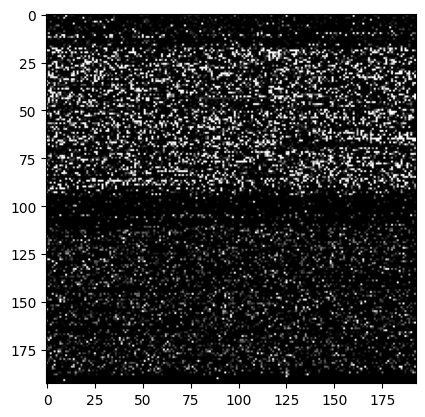

In [27]:
plt.imshow(X_tensor[0].permute(1, 2, 0))

In [28]:
torchvision.transforms.Resize(448)(X_tensor[0])

tensor([[[-0.5730, -0.5162, -0.3487,  ..., -0.4206, -0.5005, -0.5275],
         [-0.5029, -0.4521, -0.3023,  ..., -0.4131, -0.4942, -0.5217],
         [-0.2965, -0.2633, -0.1658,  ..., -0.3908, -0.4756, -0.5044],
         ...,
         [-0.0455, -0.0455, -0.0455,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0115, -0.0115, -0.0115,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.5730, -0.5162, -0.3487,  ..., -0.4206, -0.5005, -0.5275],
         [-0.5029, -0.4521, -0.3023,  ..., -0.4131, -0.4942, -0.5217],
         [-0.2965, -0.2633, -0.1658,  ..., -0.3908, -0.4756, -0.5044],
         ...,
         [-0.0455, -0.0455, -0.0455,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0115, -0.0115, -0.0115,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.5730, -0.5162, -0.3487,  ..., -0.4206, -0.5005, -0.5275],
         [-0.5029, -0.4521, -0.3023,  ..., -0

In [22]:
#from torchvision import models
#models.vit_h_14(weights=models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1)

timm.create_model('eva02_large_patch14_448.mim_m38m_ft_in22k_in1k', pretrained=True)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-23): 24 x EvaBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=1024, out_features=2730, bias=True)
        (fc1_x): Linear(in

In [30]:
%%time
from sklearn.model_selection import KFold

def get_model():
		model = timm.create_model('eva02_large_patch14_448.mim_m38m_ft_in22k_in1k', pretrained=True)

		#num_ftrs = model.fc.in_features
		#model.fc = nn.Linear(num_ftrs, len(genes))
		
		#num_ftrs = model.head.in_features
		#model.head = nn.Linear(num_ftrs, len(genes))

		#num_ftrs = model.classifier[6].in_features
		#model.classifier[6] = nn.Linear(num_ftrs, len(genes))

		num_ftrs = model.head.in_features
		model.head = nn.Linear(num_ftrs, len(genes))

		return model.cuda()

kf = KFold(n_splits=5, shuffle=True, random_state=6174)
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
		print(f'Fold {fold+1}')

		# Split data into training and validation sets
		X_train_tensor, y_train_tensor = X_tensor[train_index], y_tensor[train_index]
		X_val_tensor, y_val_tensor = X_tensor[val_index], y_tensor[val_index]
		
		# Move data to GPU
		X_train_tensor, y_train_tensor = X_train_tensor.cuda(), y_train_tensor.cuda()
		X_val_tensor, y_val_tensor = X_val_tensor.cuda(), y_val_tensor.cuda()

		# DataLoader setup
		train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
		val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
		train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
		val_loader = DataLoader(val_dataset, batch_size=16)

		# Model, loss, optimizer setup
		model = get_model()
		criterion = nn.MSELoss()
		optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
		scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

		# Training loop for each fold
		best_val_loss = float('inf')
		early_stopping_patience = 10
		early_stopping_counter = 0
		gradient_clip_value = 1
		
		for epoch in range(num_epochs):
				model.train()
				for inputs, targets in train_loader:
						optimizer.zero_grad()
						outputs = model(torchvision.transforms.Resize(448)(inputs))
						loss = criterion(outputs, targets)
						loss.backward()
						torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)  # Gradient clipping
						optimizer.step()

				# Validation loop
				model.eval()
				valid_loss_squared_sum = 0  # For MRRMSE

				with torch.no_grad():
						for inputs, targets in val_loader:
								outputs = model(torchvision.transforms.Resize(448)(inputs))
								loss = criterion(outputs, targets)
								valid_loss_squared_sum += loss.item() * inputs.size(0)  # Sum of squared errors
						valid_mrrmse = np.sqrt(valid_loss_squared_sum / len(val_loader.dataset))
						print(f'Epoch {epoch}, MRRMSE: {valid_mrrmse}')

						# Update the learning rate scheduler based on validation loss
						scheduler.step(valid_mrrmse)

						if valid_mrrmse < best_val_loss:
								best_val_loss = valid_mrrmse
								early_stopping_counter = 0
								torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')  # Save best model checkpoint
						else:
								early_stopping_counter += 1
								if early_stopping_counter >= early_stopping_patience:
										print("Early stopping triggered")
										print()
										break
		print()

Fold 1
Epoch 0, MRRMSE: 0.773417361548552
Epoch 1, MRRMSE: 0.7756001974975255
Epoch 2, MRRMSE: 0.7893533233023856
Epoch 3, MRRMSE: 0.7477055941389661
Epoch 4, MRRMSE: 0.7084869511235637
Epoch 5, MRRMSE: 0.7107507852257509
Epoch 6, MRRMSE: 0.6998929467307697
Epoch 7, MRRMSE: 0.6980326831801412
Epoch 8, MRRMSE: 0.6892536367482174
Epoch 9, MRRMSE: 0.6674914135292834
Epoch 10, MRRMSE: 0.6879661618856273
Epoch 11, MRRMSE: 0.6995572498543908
Epoch 12, MRRMSE: 0.7228305340767189
Epoch 13, MRRMSE: 0.7179777924997067
Epoch 14, MRRMSE: 0.697654082413079
Epoch 15, MRRMSE: 0.6688412705616926
Epoch 00016: reducing learning rate of group 0 to 1.0000e-04.
Epoch 16, MRRMSE: 0.6692050284704574
Epoch 17, MRRMSE: 0.6769593606457502
Epoch 18, MRRMSE: 0.6712740036108534
Epoch 19, MRRMSE: 0.6781823417372429
Early stopping triggered


Fold 2
Epoch 0, MRRMSE: 0.8222090446203223
Epoch 1, MRRMSE: 0.8475813083376535
Epoch 2, MRRMSE: 0.7862414547622159


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error


def predict(model, X_data, X_scaler=None, y_scaler=None, is_image_format=False):
    """
    Preprocess the features if needed, predict using the trained model, and inverse transform the predictions.
    """
    if X_scaler is not None and not is_image_format:
        X_scaled = X_scaler.transform(X_data)
        X_img = convert_to_image_format(X_scaled)
        X_tensor = torch.tensor(X_img, dtype=torch.float32).permute(0, 3, 1, 2).cuda()
    else:
        X_tensor = X_data

    model.eval()
    with torch.no_grad():
        test_outputs = model(torchvision.transforms.Resize(448)(X_tensor))
        
    test_predictions = test_outputs.cpu().numpy()
    if y_scaler is not None:
        test_predictions = y_scaler.inverse_transform(test_predictions)
    
    return test_predictions

ensemble_cv_predictions = []

# Load models and collect their predictions for the validation and test set
for fold in range(1, 6):
    # Load the pre-trained model
    model = get_model()
    checkpoint_path = f'best_model_fold_{fold}.pth'
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.cuda()
    
    # Make predictions on the validation set
    # X_val_tensor is already in image format, no need for scaling
    val_predictions = predict(model, X_val, X_scaler=X_scaler, y_scaler=y_scaler)
    ensemble_cv_predictions.append(val_predictions)
    
  
# Calculate the average prediction across all folds
ensemble_cv_predictions = np.mean(ensemble_cv_predictions, axis=0)

# We can also calculate the ensemble CV score if 'y_val_tensor' holds the true validation labels
ensemble_mrrmse = np.sqrt(mean_squared_error(ensemble_cv_predictions, y_val))
print(f'Ensemble CV MRRMSE: {ensemble_mrrmse}')

Ensemble CV MRRMSE: 1.6962981166790008


In [ ]:
# Train again by using all data

X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Assuming de_features and genes are defined elsewhere in your script
X_scaled = X_scaler.fit_transform(X.values)
y_scaled = y_scaler.fit_transform(y.values)

# Convert scaled data to image format
X_img = convert_to_image_format(X_scaled)

# Convert to tensors
X_tensor = torch.tensor(X_img, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# KFold setup
num_epochs = 50  # Define the number of epochs


kf = KFold(n_splits=5, shuffle=True, random_state=6174)
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
    print(f'Fold {fold+1}')

    # Split data into training and validation sets
    X_train_tensor, y_train_tensor = X_tensor[train_index], y_tensor[train_index]
    X_val_tensor, y_val_tensor = X_tensor[val_index], y_tensor[val_index]
    
    # Move data to GPU
    X_train_tensor, y_train_tensor = X_train_tensor.cuda(), y_train_tensor.cuda()
    X_val_tensor, y_val_tensor = X_val_tensor.cuda(), y_val_tensor.cuda()

    # DataLoader setup
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Model, loss, optimizer setup
    model = get_model()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Training loop for each fold
    best_val_loss = float('inf')
    early_stopping_patience = 10
    early_stopping_counter = 0
    gradient_clip_value = 1
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)  # Gradient clipping
            optimizer.step()

        # Validation loop
        model.eval()
        valid_loss_squared_sum = 0  # For MRRMSE

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss_squared_sum += loss.item() * inputs.size(0)  # Sum of squared errors
            valid_mrrmse = np.sqrt(valid_loss_squared_sum / len(val_loader.dataset))
            print(f'Epoch {epoch}, MRRMSE: {valid_mrrmse}')

            # Update the learning rate scheduler based on validation loss
            scheduler.step(valid_mrrmse)

            if valid_mrrmse < best_val_loss:
                best_val_loss = valid_mrrmse
                early_stopping_counter = 0
                torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')  # Save best model checkpoint
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    print()
                    break
    print()


ensemble_sub_predictions = []
for fold in range(1, 6):
    # Load the pre-trained model
		model = get_model()
		checkpoint_path = f'best_model_fold_{fold}.pth'
		model.load_state_dict(torch.load(checkpoint_path))
		model = model.cuda()
		
		# Make predictions on the test set
		# X_sub_tensor is already in image format, no need for scaling
		sub_predictions = predict(model, X_sub, X_scaler=X_scaler, y_scaler=y_scaler)
		ensemble_sub_predictions.append(sub_predictions)
	
# Calculate the average prediction across all folds
ensemble_sub_predictions = np.mean(ensemble_sub_predictions, axis=0)

# Save the predictions to a CSV file
id_map.loc[:, genes] = ensemble_sub_predictions
id_map = id_map.loc[:, ["id"] + genes.to_list()]
id_map.to_csv('submission.csv', index=False)
id_map